# Data Preprocessing and Feature Engineering


This notebook focuses on data preprocessing and feature engineering for the ride completion prediction task. For each transformation, we'll:
1. Visualize the impact of the preprocessing step, comparing it against the target label.
2. Conclude whether to include the transformation based on its effectiveness.


## 1. Load the Data

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_df = pd.read_csv('data/task_train_processed.csv')
train_df = train_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Display the first few rows to confirm the data is loaded correctly
train_df.head()


,ID,UserID,Origin,Destination,Time,Income,Comment,Created_at,Label
0,1001034,1001513,1030,1030,9,230000,\n,2024-04-13 10:07:38.022905,0
1,1005544,1001129,631,847,42,1060000,راننده بسیار مودب بود و خوشرو بود\n,2024-04-15 12:15:10.609723,0
2,1000139,1004333,858,864,34,1250000,سفر بسیار اسان و راحتی بود، و ماشین تمیزتمیز ...,2024-04-13 02:18:36.600126,0
3,1000560,1001673,593,846,14,660000,راننده به موقع رسید\n,2024-04-13 06:00:18.870376,1
4,1008230,1002231,1018,1018,11,230000,ماشین بسیار شیک بود و راننده از هر لحاظ حرفه...,2024-04-16 16:31:47.874442,0


## Visualization Function

In [5]:

# Function to plot before and after transformation and compare against the label
def plot_comparison_with_label(original_feature, transformed_feature, title_original, title_transformed):
    plt.figure(figsize=(14, 6))
    
    # Plot original feature vs. Label
    plt.subplot(1, 2, 1)
    sns.histplot(data=train_df, x=original_feature, hue='Label', kde=True, palette='viridis', element='step')
    plt.title(title_original)
    
    # Plot transformed feature vs. Label
    plt.subplot(1, 2, 2)
    sns.countplot(x=transformed_feature, hue='Label', data=train_df, palette='viridis')
    plt.title(title_transformed)
    
    plt.show()


## 2. Time Buckets

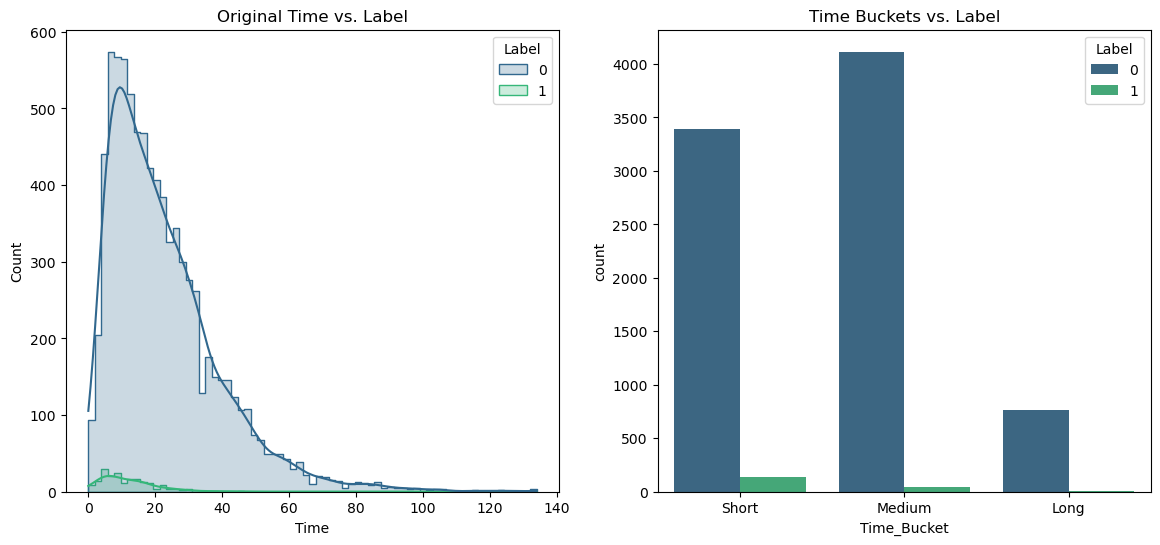

In [6]:

train_df['Time_Bucket'] = pd.cut(train_df['Time'], bins=[0, 15, 45, np.inf], labels=['Short', 'Medium', 'Long'])
plot_comparison_with_label('Time', 'Time_Bucket', 'Original Time vs. Label', 'Time Buckets vs. Label')


### Conclusion:

The Time_Bucket feature, which categorizes ride durations into Short, Medium, and Long buckets, shows a meaningful distinction between finished and unfinished rides:

Short Rides: The majority of unfinished rides fall into the Short category, suggesting that shorter rides are more prone to being incomplete. This makes the Short bucket particularly useful for identifying rides at risk of not being completed.
Medium Rides: The Medium bucket contains the majority of finished rides, indicating that rides of moderate duration are more likely to be completed.
Long Rides: The Long bucket has very few rides, and these are almost all completed, which suggests that rides of longer duration are less likely to be abandoned.
Decision: The Time_Bucket feature is valuable for the model, as it provides a clear differentiation between finished and unfinished rides, particularly within the Short and Medium categories. However, due to the limited data in the Long category, it may be worth considering merging this bucket with the Medium category or adjusting the thresholds. Overall, the Time_Bucket feature should be included in the model to help improve the prediction of ride completion.


## 3. Flagging High-Income Short Rides

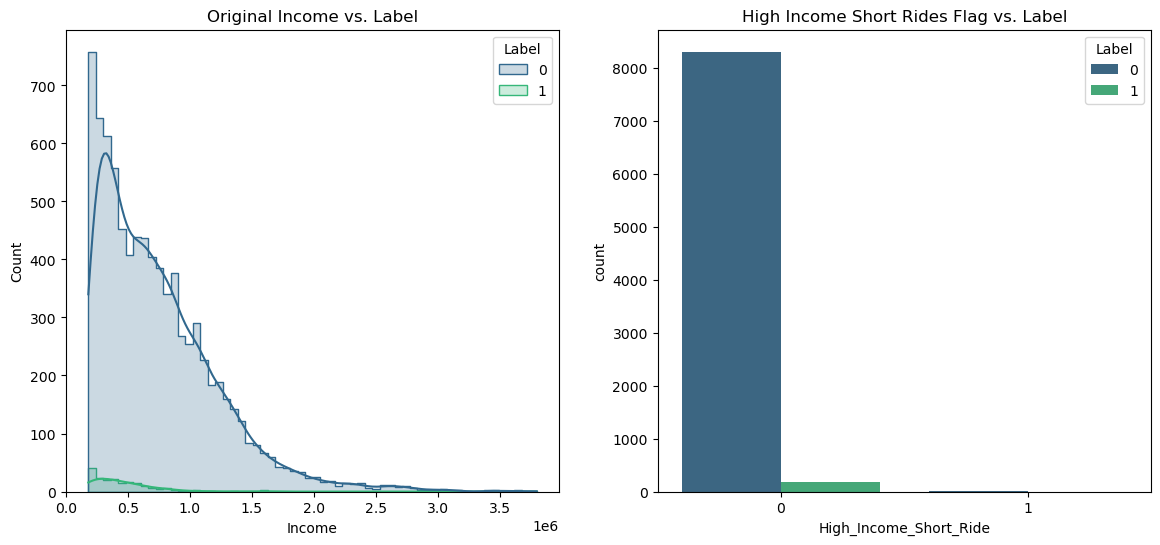

In [7]:

high_income_threshold = train_df['Income'].quantile(0.95)
train_df['High_Income_Short_Ride'] = np.where((train_df['Time'] <= 15) & (train_df['Income'] >= high_income_threshold), 1, 0)
plot_comparison_with_label('Income', 'High_Income_Short_Ride', 'Original Income vs. Label', 'High Income Short Rides Flag vs. Label')


### Conclusion:


Evaluate the plot to determine if flagging high-income short rides provides a useful distinction in predicting ride completion. If the flag is effective, it should be included.


## 4. Duration Categories

In [8]:

train_df['Duration_Category'] = pd.cut(train_df['Time'], bins=[0, 10, 30, 60, np.inf], labels=['Very Short', 'Short', 'Medium', 'Long'])


## 5. Income Per Minute

In [9]:

train_df['Income_Per_Minute'] = train_df['Income'] / train_df['Time']


## 6. Outlier Detection: Capping

In [10]:

income_cap = train_df['Income'].quantile(0.95)
train_df['Income_Capped'] = np.where(train_df['Income'] > income_cap, income_cap, train_df['Income'])

## 7. Log Transformation of Income

In [11]:

train_df['Income_Log'] = np.log1p(train_df['Income'])

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      8500 non-null   int64   
 1   UserID                  8500 non-null   int64   
 2   Origin                  8500 non-null   int64   
 3   Destination             8500 non-null   int64   
 4   Time                    8500 non-null   int64   
 5   Income                  8500 non-null   int64   
 6   Comment                 8500 non-null   object  
 7   Created_at              8500 non-null   object  
 8   Label                   8500 non-null   int64   
 9   Time_Bucket             8452 non-null   category
 10  High_Income_Short_Ride  8500 non-null   int64   
 11  Duration_Category       8452 non-null   category
 12  Income_Per_Minute       8500 non-null   float64 
 13  Income_Capped           8500 non-null   float64 
 14  Income_Log              

/var/folders/_v/41jjhnl13mbbj8tvqvcz7mpc0000gn/T/ipykernel_89494/3212243293.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')


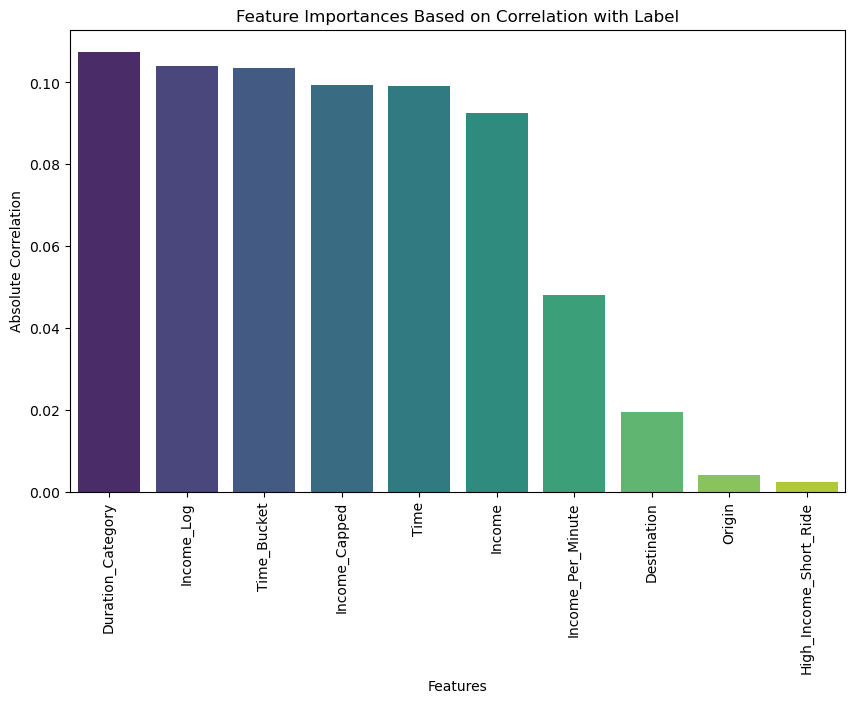

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named train_df
df = train_df.copy()

# Define the features to exclude
irrelevant_features = ['ID', 'UserID', 'Comment', 'Created_at']

# Drop irrelevant features
df_relevant = df.drop(columns=irrelevant_features)

# Encode categorical features
label_encoders = {}
for column in df_relevant.select_dtypes(include=['category']).columns:
    le = LabelEncoder()
    df_relevant[column] = le.fit_transform(df_relevant[column])
    label_encoders[column] = le

# Calculate correlation with the label for numerical features
correlations = df_relevant.corr()['Label'].abs().sort_values(ascending=False)

# Drop the 'Label' itself from the correlations
correlations = correlations.drop('Label')

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Feature Importances Based on Correlation with Label')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()


## 8. Save the Processed Data

In [17]:

# Save the processed DataFrame to a new CSV file
train_df.to_csv('data/task_train_processed.csv', index=False)

print("Processed data saved to 'data/task_train_processed.csv'")


Processed data saved to 'data/task_train_processed.csv'
